In [2]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D

In [97]:
random.seed(1314)

def Mean(data):
    return np.mean(data,axis=1)

def Std(data):
    return np.std(data,axis=1)

def Var(data):
    return np.var(data,axis=1)

def Skew(data):
    return stats.skew(data,axis=1)



In [99]:
random_data1 = (np.random.normal(20,10,50000)).reshape(5000,10,1)
random_data2 = (np.random.normal(50,30,200000)).reshape(20000,10,1)
random_data3 = (np.random.normal(100,60,200000)).reshape(20000,10,1)
random_data4 = (np.random.normal(500,300,200000)).reshape(20000,10,1)
random_data5 = (np.random.normal(1000,700,200000)).reshape(20000,10,1)
random_data6 = (np.random.normal(1000,50,200000)).reshape(20000,10,1)
random_data7 = (np.random.normal(1000,6,200000)).reshape(20000,10,1)


data = np.concatenate( (random_data1,random_data2) )
data = np.concatenate( (data,random_data3) )
data = np.concatenate( (data,random_data4) )
data = np.concatenate( (data,random_data5) )
data = np.concatenate( (data,random_data6) )
data = np.concatenate( (data,random_data7) )



val_data2 = (np.random.normal(500,250,20000)).reshape(2000,10,1)


In [100]:
mean_data = Mean(data)
std_data = Std(data)
skew_data = Skew(data)

mean_datav = Mean(val_data2)
std_datav = Std(val_data2)
skew_datav = Skew(val_data2)

In [140]:
# preload models
stdModel = load_model('./std2.h5')
meanModel = load_model('./mean2.h5')

# Skewness

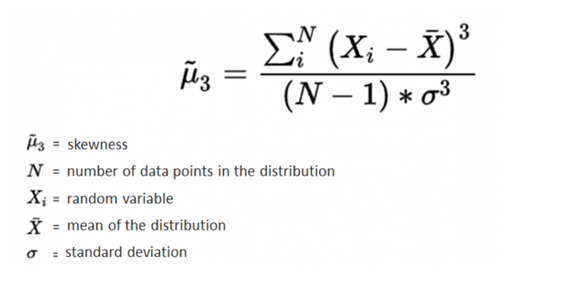

In [130]:
# code merged mean/ std as layers then output skew (not work too well)


input_layer = keras.Input(shape=(10,1))
x = Flatten()(input_layer)
#x = BatchNormalization(axis=1)(x)
# numerator
mean_1 = Dense(64, activation='relu')(x)
mean_2 = Dense(64, activation='relu')(mean_1)
mean_out = Dense(1, activation = 'relu', name = 'mean')(mean_2)

# denominator
std_1 = Dense(64, activation='relu')(x)
std_2 = Dense(64, activation='relu')(std_1)
std_out = Dense(1, activation = 'relu', name = 'std')(std_2)

n_d = concatenate([mean_out,std_out])
skew1 = Dense(128, activation='relu')(n_d)
skew2 = Dense(128, activation='relu')(skew1)
skew3 = Dense(128, activation='relu')(skew2)

skew_out = Dense(1, activation = 'linear', name= 'skewness')(skew3)

skewModel = keras.Model(input_layer, [mean_out,std_out,skew_out ], name= "skew")

In [131]:
skewModel.compile(optimizer="adam", loss="mean_squared_error")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

In [85]:
skewModel.summary()

Model: "skew"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 10)           0           input_14[0][0]                   
__________________________________________________________________________________________________
dense_93 (Dense)                (None, 64)           704         flatten_13[0][0]                 
__________________________________________________________________________________________________
dense_95 (Dense)                (None, 64)           704         flatten_13[0][0]                 
_______________________________________________________________________________________________

In [86]:
# standard DL

# skewModel = Sequential([
# keras.layers.Flatten(input_shape=(10,1)),
# Dense(128,activation='relu'),
# Dense(128,activation='relu'),
# Dense(64,activation='relu'),
# Dense(64,activation='relu'),           

# Dense(32, activation ='relu'),
# Dense(1, activation ='linear')
# ])

In [101]:

# skewModel.fit(random_data2, [mean_data2,std_data2,skew_data2 ], 
#               #validation_data=([val_data2,[mean_data2v,std_data2v,skew_data2v]]), 
#               epochs=1000, batch_size=128,
#           #  callbacks=[es],
#                 shuffle=True)


#skewModel.fit(random_data2, [mean_data2,std_data2,skew_data2 ], epochs=1000, batch_size=128)

In [151]:
# code train mean model first, std second, and call the models to train skew

# mean model
meanModel = Sequential([
keras.layers.Flatten(input_shape=(10,1)),
Dense(64,activation='relu'),
Dense(64,activation='relu'),
Dense(1, activation ='linear')
])

In [152]:
meanModel.compile(optimizer="adam", loss="mean_squared_error")
meanModel.fit(data, mean_data, 
              epochs=1000, batch_size=128,
                shuffle=True)

Epoch 1/1000
665/665 [==============================] - 2s 2ms/step - loss: 26114.7936
Epoch 2/1000
665/665 [==============================] - 1s 2ms/step - loss: 222.8362
Epoch 3/1000
665/665 [==============================] - 1s 2ms/step - loss: 109.6868
Epoch 4/1000
665/665 [==============================] - 1s 2ms/step - loss: 62.8753
Epoch 5/1000
665/665 [==============================] - 1s 2ms/step - loss: 36.1056
Epoch 6/1000
665/665 [==============================] - 1s 2ms/step - loss: 20.3839
Epoch 7/1000
665/665 [==============================] - 1s 2ms/step - loss: 13.5884
Epoch 8/1000
665/665 [==============================] - 1s 2ms/step - loss: 9.4302
Epoch 9/1000
665/665 [==============================] - 1s 2ms/step - loss: 6.3500
Epoch 10/1000
665/665 [==============================] - 1s 2ms/step - loss: 18.9706
Epoch 11/1000
665/665 [==============================] - 1s 2ms/step - loss: 5.5737
Epoch 12/1000
665/665 [==============================] - 1s 2ms/step - l

KeyboardInterrupt: 

In [184]:
# std model

stdModel = Sequential([
keras.layers.Flatten(input_shape=(10,1)),
Dense(64,activation='relu'),
Dense(128,activation='relu'),
Dense(64,activation='relu'),
Dense(32,activation='relu'),
Dense(1, activation ='linear')
])

In [101]:
stdModel.compile(optimizer="adam", loss="mean_squared_error")
stdModel.fit(data, std_data, 
              epochs=1000, batch_size=128,
                shuffle=True)

Epoch 1/1000
977/977 [==============================] - 3s 2ms/step - loss: 3.1804
Epoch 2/1000
977/977 [==============================] - 2s 3ms/step - loss: 2.9626
Epoch 3/1000
977/977 [==============================] - 2s 2ms/step - loss: 2.6885
Epoch 4/1000
977/977 [==============================] - 2s 2ms/step - loss: 2.7092
Epoch 5/1000
977/977 [==============================] - 2s 2ms/step - loss: 2.7316
Epoch 6/1000
977/977 [==============================] - 2s 2ms/step - loss: 2.6809
Epoch 7/1000
675/977 [===================>..........] - ETA: 0s - loss: 2.4866

KeyboardInterrupt: 

In [109]:
input_layer = keras.Input(shape=(10,1))
x = Flatten()(input_layer)
#x = BatchNormalization(axis=1)(x)
# numerator
numerator = meanModel(x)
denum = stdModel(x)

n_d = concatenate([numerator,denum])

skew1 = Dense(64, activation='relu')(n_d)
skew2 = Dense(64, activation='relu')(skew1)


skew_out = Dense(1, activation = 'linear', name= 'skewness')(skew2)



skewModel = keras.Model(input_layer, skew_out, name= "skew")

In [141]:
skewModel.compile(optimizer="adam", loss="mean_squared_error")
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)

In [142]:
skewModel.fit(data, skew_data,
             # validation_data=(val_data2,skew_datav), 
              epochs=1000,
              #callbacks=[es],
              batch_size=128, shuffle=True)

Epoch 1/1000
977/977 [==============================] - 5s 3ms/step - loss: 0.0305
Epoch 2/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0231
Epoch 3/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0232
Epoch 4/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0207
Epoch 5/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0250
Epoch 6/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0211
Epoch 7/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0206
Epoch 8/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0201
Epoch 9/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0221
Epoch 10/1000
977/977 [==============================] - 3s 3ms/step - loss: 0.0214
Epoch 11/1000
233/977 [======>.......................] - ETA: 2s - loss: 0.0254

KeyboardInterrupt: 

1/1 [==============================] - 0s 33ms/step


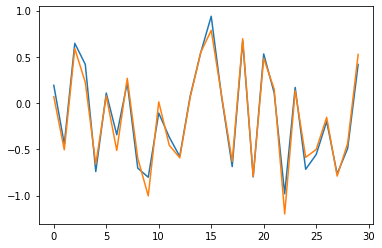

In [151]:
Predirect_arr2 = (np.random.normal(10000,500,300)).reshape(30,10,1)
# plt.plot(range(30),Skew(Predirect_arr2),range(30), skewModel.predict(Predirect_arr2))

#method 1 testing
# plt.plot(range(30),np.mean(Predirect_arr2, axis=1),range(30), skewModel.predict(Predirect_arr2)[0])
# plt.plot(range(30),np.std(Predirect_arr2, axis=1),range(30), skewModel.predict(Predirect_arr2)[1])
#plt.plot(range(30),Skew(Predirect_arr2),range(30), skewModel.predict(Predirect_arr2)[2])

#method 2 testing
#plt.plot(range(30),np.mean(Predirect_arr2, axis=1),range(30), meanModel.predict(Predirect_arr2))
#plt.plot(range(30),np.std(Predirect_arr2, axis=1),range(30), stdModel.predict(Predirect_arr2))
plt.plot(range(30),Skew(Predirect_arr2),range(30), skewModel.predict(Predirect_arr2))

In [148]:
#skewModel.save("./skew2.h5")
#meanModel.save("./mean2.h5")
#stdModel.save("./std2.h5")